<a href="https://colab.research.google.com/github/ShravyaDsouza/DownSyndromeDetection/blob/main/DownSyndromeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import cv2
import numpy as np
import re
import os

In [ ]:
file_path = "/content/ObjectDetection.xlsx"

In [ ]:
df = pd.read_excel(file_path)

In [ ]:
distinct_struct = df["structure"].unique().tolist()

In [ ]:
print(distinct_struct)

['thalami', 'nasal bone', 'palate', 'nasal skin', 'nasal tip', 'midbrain', 'NT', 'IT', 'CM']


In [ ]:
processed_data = []

In [ ]:
output_excel_path = 'Image_Metadata.xlsx'

In [ ]:
files_path = "/content/Training Dataset"

In [ ]:
files = os.listdir(files_path)

In [ ]:
file_list = [f for f in os.listdir(files_path) if os.path.isfile(os.path.join(files_path, f))]

In [ ]:
file_count = len(file_list)
print(f"Number of files in '{files_path}': {file_count}")

Number of files in '/content/Training Dataset': 27


In [ ]:
for renamed_file in files:
    match = re.search(r"(\d+\.png)$", renamed_file)
    if match:
        original_file_name = match.group(1)

        nt_thickness = None
        classification = "Invalid"
        noisy_flag = 1
        h_min, h_max, w_min, w_max = None, None, None, None

        image_rows = df[df['fname'] == original_file_name]

        nt_rows = image_rows[image_rows['structure'] == 'NT']
        if not nt_rows.empty:
            nt_entry = nt_rows.iloc[0]
            h_min = nt_entry['h_min']
            h_max = nt_entry['h_max']
            w_min = nt_entry['w_min']
            w_max = nt_entry['w_max']

            nt_thickness = (h_max - h_min) / 10

            noisy_flag = 0
            if nt_thickness > 3:
                classification = "High Risk"
            elif nt_thickness <= 3:
                classification = "Low Risk"

        processed_data.append({
            "image_name": renamed_file,
            "NT_thickness_mm": nt_thickness,
            "h_min": h_min,
            "h_max": h_max,
            "w_min": w_min,
            "w_max": w_max,
            "classification": classification,
            "noisy_flag": noisy_flag
        })

processed_df = pd.DataFrame(processed_data)
processed_df.to_excel(output_excel_path, index=False)

print(f"Processed data saved to '{output_excel_path}'.")

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [ ]:
image_folder = "/content/drive/MyDrive/Colab Notebooks/Training Dataset"
excel_path = "/content/Image_Metadata.xlsx"
#output_model_path = "xception_nt_classification.h5"

In [ ]:
df = pd.read_excel(excel_path)
df.head()

,image_name,NT_thickness_mm,h_min,h_max,w_min,w_max,classification,noisy_flag
0,Set1-Training&Validation Sets CNN_Standard_663...,3.5,382.0,417.0,159.0,358.0,High Risk,0
1,Set1-Training&Validation Sets CNN_Standard_537...,2.9,335.0,364.0,263.0,544.0,Low Risk,0
2,Set1-Training&Validation Sets CNN_Standard_268...,1.5,287.0,302.0,276.0,349.0,Low Risk,0
3,Set1-Training&Validation Sets CNN_Standard_615...,4.1,379.0,420.0,245.0,639.0,High Risk,0
4,Set2-Training&Validation Sets ANN Scoring syst...,NaN,NaN,NaN,NaN,NaN,Invalid,1


In [ ]:
X = []  # Images
y = []  # Labels

In [ ]:
label_map = {"High Risk": 1, "Low Risk": 0, "Invalid": 2}

In [ ]:
# ROI Extraction
for _, row in df.iterrows():
    image_path = os.path.join(image_folder, row["image_name"])

    if os.path.exists(image_path):
        if row["classification"] == "Invalid" or pd.isna(row["h_min"]):
            img = cv2.imread(image_path)

            roi_resized = cv2.resize(img, (224, 224))
            roi_preprocessed = preprocess_input(roi_resized)

            X.append(roi_preprocessed)
            y.append(label_map["Invalid"])
            continue

        h_min, h_max = int(row["h_min"]), int(row["h_max"])
        w_min, w_max = int(row["w_min"]), int(row["w_max"])

        img = cv2.imread(image_path)
        roi = img[h_min:h_max, w_min:w_max]

        roi_resized = cv2.resize(roi, (224, 224))
        roi_preprocessed = preprocess_input(roi_resized)

        X.append(roi_preprocessed)
        y.append(label_map[row["classification"]])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
y = to_categorical(y, num_classes=3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1)
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.2449223416965352, 1: 0.8040123456790124, 2: 1.0493454179254784}


In [ ]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])

In [ ]:
#optimizer=Adam(learning_rate=1e-5)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.7446 - loss: 0.5158 - val_accuracy: 0.7318 - val_loss: 0.4609
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.7474 - loss: 0.4535 - val_accuracy: 0.7318 - val_loss: 0.4602
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.7182 - loss: 0.4722 - val_accuracy: 0.7318 - val_loss: 0.4589
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.7474 - loss: 0.4414 - val_accuracy: 0.7318 - val_loss: 0.4583
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.7426 - loss: 0.4488 - val_accuracy: 0.7318 - val_loss: 0.4593
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.7347 - loss: 0.4521 - val_accuracy: 0.7318 - val_loss: 0.4580
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.7248 - loss: 0.4686 - val_accuracy: 0.7318 - val_loss: 0.4754
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.7332 - loss: 0.4759 - val_accu

In [ ]:
model.save("trained_xception.keras")

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 503ms/step - accuracy: 0.9613 - loss: 0.1572 - val_accuracy: 0.9464 - val_loss: 0.1383
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.9731 - loss: 0.1065 - val_accuracy: 0.9425 - val_loss: 0.1382
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.9861 - loss: 0.0835 - val_accuracy: 0.9387 - val_loss: 0.1382
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.9806 - loss: 0.0820 - val_accuracy: 0.9387 - val_loss: 0.1373
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.9824 - loss: 0.0828 - val_accuracy: 0.9349 - val_loss: 0.1370
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.9765 - loss: 0.0991 - val_accuracy: 0.9349 - val_loss: 0.1364
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9909 - loss: 0.0539 - val_accuracy: 0.9387 - val_loss: 0.1364
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.9778 - loss: 0.0775 - val_accu

In [ ]:
model.save("fine_tuned_xception.keras")

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8051 - loss: 0.5499
Validation Loss: 0.4995
Validation Accuracy: 0.8084


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=["Low Risk", "High Risk", "Invalid"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val_true_classes, y_val_pred_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.58      0.99      0.73        70
   High Risk       0.99      0.71      0.83       108
     Invalid       1.00      0.78      0.88        83

    accuracy                           0.81       261
   macro avg       0.86      0.83      0.81       261
weighted avg       0.88      0.81      0.82       261


Confusion Matrix:
[[69  1  0]
 [31 77  0]
 [18  0 65]]


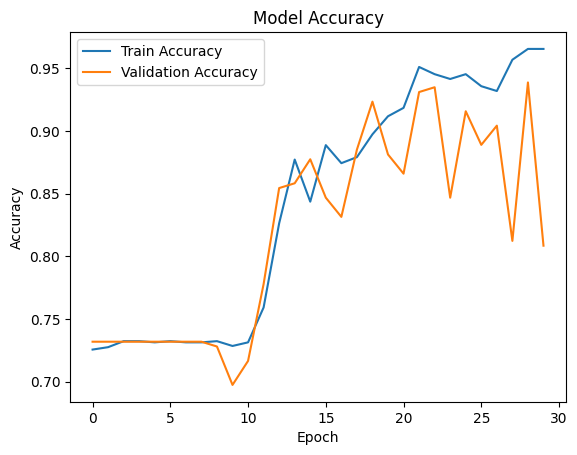

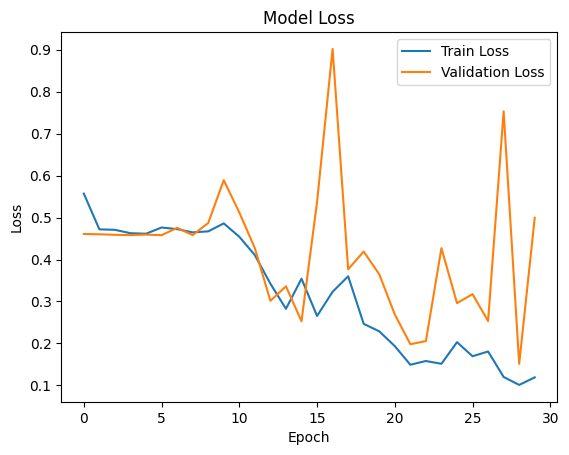

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#For Fine Tuned

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9513 - loss: 0.1177
Validation Loss: 0.1402
Validation Accuracy: 0.9425


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=["Low Risk", "High Risk", "Invalid"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val_true_classes, y_val_pred_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.92      0.86      0.89        70
   High Risk       0.91      0.95      0.93       108
     Invalid       1.00      1.00      1.00        83

    accuracy                           0.94       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.94      0.94      0.94       261


Confusion Matrix:
[[ 60  10   0]
 [  5 103   0]
 [  0   0  83]]


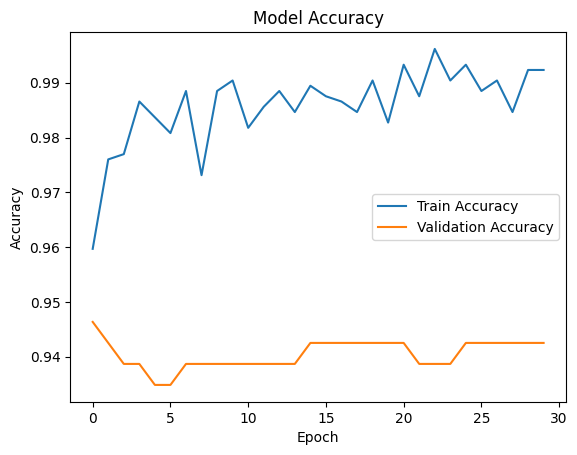

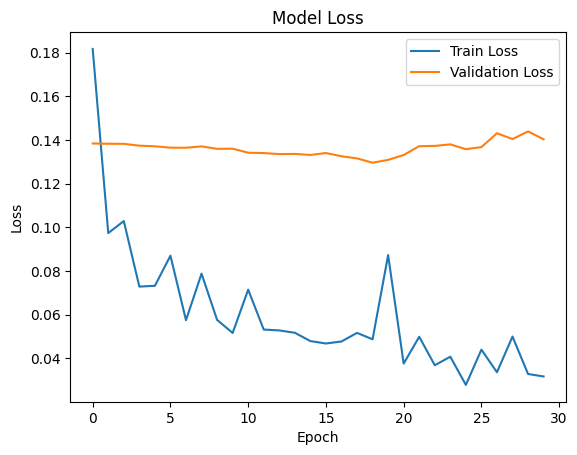

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
from tensorflow.keras.regularizers import l2

for layer in base_model.layers[:-10]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8927 - loss: 1.7662 - val_accuracy: 0.8966 - val_loss: 1.7063
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8894 - loss: 1.7628 - val_accuracy: 0.8927 - val_loss: 1.6955
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.8951 - loss: 1.7606 - val_accuracy: 0.8927 - val_loss: 1.6865
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.8855 - loss: 1.7536 - val_accuracy: 0.9004 - val_loss: 1.6777
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.8742 - loss: 1.7588 - val_accuracy: 0.9004 - val_loss: 1.6712
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8979 - loss: 1.7270 - val_accuracy: 0.9004 - val_loss: 1.6634
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8544 - loss: 1.7613 - val_accuracy: 0.9004 - val_loss: 1.6548
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9004 - loss: 1.7107 - val_accuracy: 0.9004

In [ ]:
model.save("fine-tuned_xception_more_param.keras")

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9071 - loss: 1.5544
Validation Loss: 1.5620
Validation Accuracy: 0.9157


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=["Low Risk", "High Risk", "Invalid"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val_true_classes, y_val_pred_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.83      0.86      0.85        70
   High Risk       0.91      0.89      0.90       108
     Invalid       1.00      1.00      1.00        83

    accuracy                           0.92       261
   macro avg       0.91      0.92      0.91       261
weighted avg       0.92      0.92      0.92       261


Confusion Matrix:
[[60 10  0]
 [12 96  0]
 [ 0  0 83]]


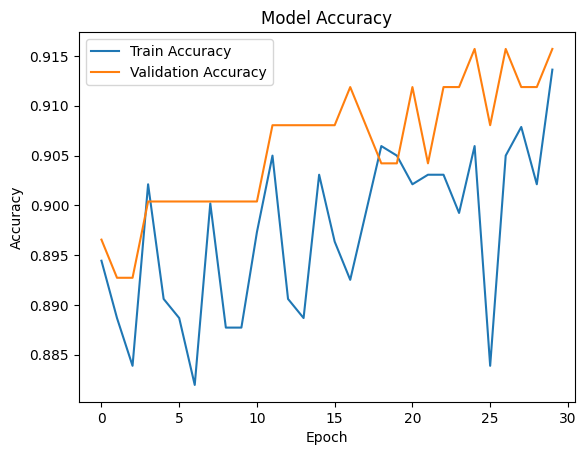

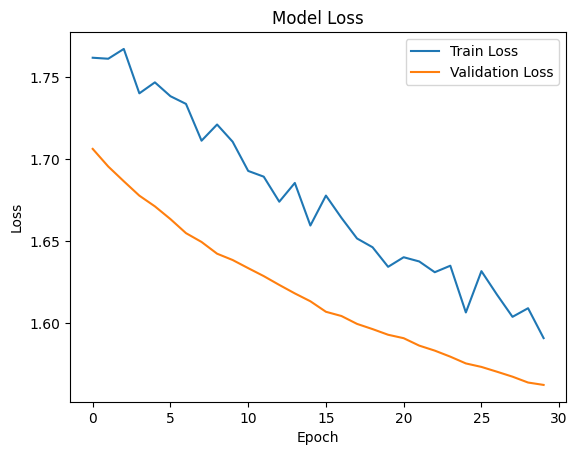

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4001 - loss: 1.0881 - val_accuracy: 0.4138 - val_loss: 1.0793
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4167 - loss: 1.0857 - val_accuracy: 0.4138 - val_loss: 1.0790
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4173 - loss: 1.0818 - val_accuracy: 0.4138 - val_loss: 1.0790
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4354 - loss: 1.0774 - val_accuracy: 0.4138 - val_loss: 1.0789
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4018 - loss: 1.0830 - val_accuracy: 0.4138 - val_loss: 1.0789
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4468 - loss: 1.0720 - val_accuracy: 0.4138 - val_loss: 1.0788
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4034 - loss: 1.0843 - val_accuracy: 0.4138 - val_loss: 1.0788
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3803 - loss: 1.0903 - val_accuracy: 0.4138 - v

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4114 - loss: 1.0728
Validation Loss: 1.0770
Validation Accuracy: 0.4138


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=["Low Risk", "High Risk", "Invalid"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val_true_classes, y_val_pred_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00        70
   High Risk       0.41      1.00      0.59       108
     Invalid       0.00      0.00      0.00        83

    accuracy                           0.41       261
   macro avg       0.14      0.33      0.20       261
weighted avg       0.17      0.41      0.24       261


Confusion Matrix:
[[  0  70   0]
 [  0 108   0]
 [  0  83   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


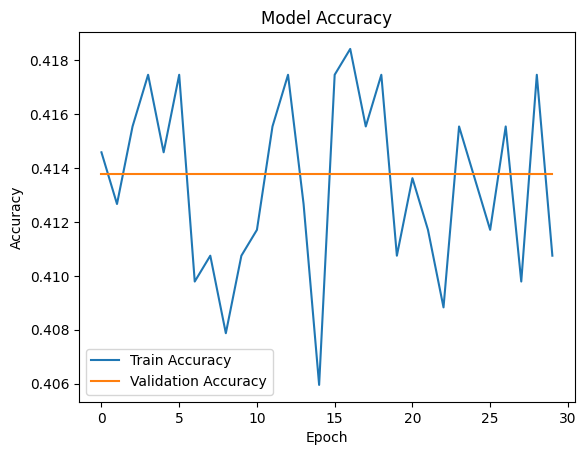

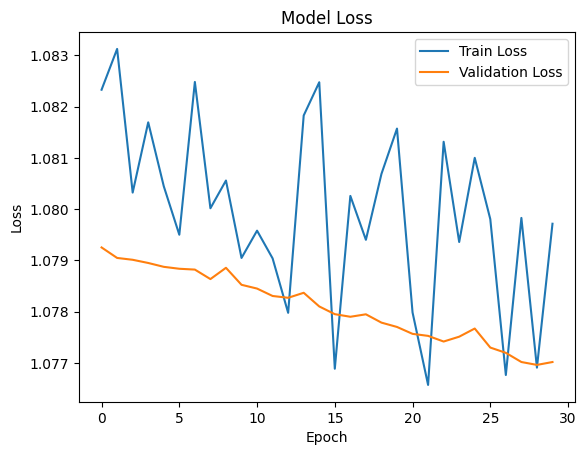

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_finetune = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    verbose=1
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8710 - loss: 0.3420 - val_accuracy: 0.8774 - val_loss: 0.2943
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8756 - loss: 0.3096 - val_accuracy: 0.8774 - val_loss: 0.2915
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8846 - loss: 0.2953 - val_accuracy: 0.8774 - val_loss: 0.2893
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8766 - loss: 0.3193 - val_accuracy: 0.8774 - val_loss: 0.2868
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8699 - loss: 0.3322 - val_accuracy: 0.8812 - val_loss: 0.2842
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9070 - loss: 0.3002 - val_accuracy: 0.8774 - val_loss: 0.2818
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8644 - loss: 0.3174 - val_accuracy: 0.8812 - val_loss: 0.2788
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.8880 - loss: 0.2925 - val_accuracy: 0.881

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9126 - loss: 0.2189
Validation Loss: 0.2380
Validation Accuracy: 0.8966


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=["Low Risk", "High Risk", "Invalid"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val_true_classes, y_val_pred_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.77      0.89      0.82        70
   High Risk       0.92      0.82      0.87       108
     Invalid       1.00      1.00      1.00        83

    accuracy                           0.90       261
   macro avg       0.89      0.90      0.90       261
weighted avg       0.90      0.90      0.90       261


Confusion Matrix:
[[62  8  0]
 [19 89  0]
 [ 0  0 83]]


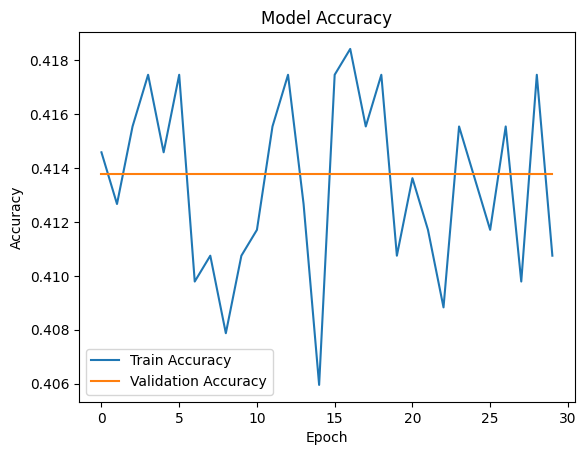

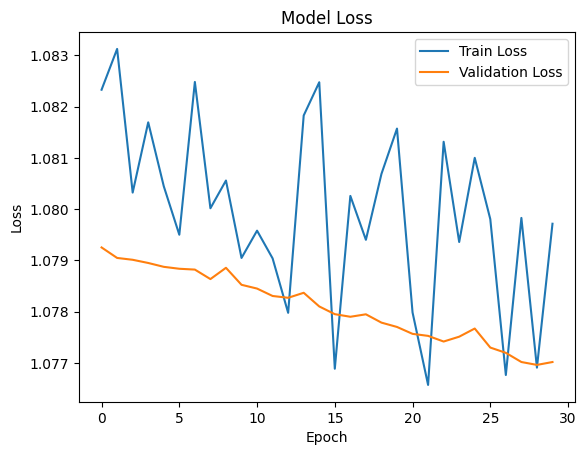

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.save("fine_tuned_EfficientNet.keras")